<a id='top'></a>
<a name="top"></a><!--Need for Colab-->
# Quick introduction to TensorFlow Serving

## MNIST CNN Model on Colab

Using subprocess module, trained / saved / loaded MNIST model, and HTTP requests-logging with TensorFlow Serving on Colab.

This is a bit more complicated than using Docker.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/gbih/ml/blob/main/tf_server/03_tfserver_mnist_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

1. [Setup](#setup)
2. [Introduction](#2.0)
3. [Using subprocess with TensorFlow Serving](#3.0)
4. [Train, save and load a MNIST model](#4.0)
    * 4.1 [Inspect the SavedModel Signature](#4.1)
5. [HTTP Request Logging for TensorFlow Serving](#5.0)
6. [Running TensorFlow Serving on Colab](#6.0)
7. [Health check](#7.0)
    * 7.1 [Verify response](#7.1)
    * 7.2 [Verify logs](#7.2)
8. [Predict requests via POST](#8.0)
9. [End and clean up processes](#9.0)

In [ ]:
# Do the following before initializing TensorFlow 
import os
os.environ["TF_CPP_VMODULE"] = 'http_server=1'

---
<a name="setup"></a>
# 1. Setup
<a href="#top">[back to top]</a>

In [ ]:
# standard library imports
import asyncio
import glob
import json
import os
from pathlib import Path
import pprint
import shlex
import subprocess
import sys
import time

# third party imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Check platform (Colab or Kaggle)
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    !pip install -q requests
    !pip install watermark -q

import requests

# For debugging, provides version & hardware info
# Load watermark magic extension
%load_ext watermark
%watermark --python --packages matplotlib,numpy,requests,tensorflow

pp = pprint.PrettyPrinter(indent=2)

def HR():
    print("-"*40)

print("Finished loading packages..")

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

matplotlib: 3.2.2
numpy     : 1.21.6
requests  : 2.23.0
tensorflow: 2.8.2+zzzcolab20220719082949

Finished loading packages..


---
<a id="2.0"></a><a name="2.0"></a>
# 2. Introduction
<a href="#top">[back to top]</a>

We explore these tasks here:

* Using subprocess with TensorFlow Serving.
* Train / save / load the MNIST model.
* Configuring and running TensorFlow Server without using Docker. 

---
<a id="3.0"></a><a name="3.0"></a>
# 3. Using subprocess with TensorFlow Serving
<a href="#top">[back to top]</a>

The older method of running CLI commands in Python involved using either os.system or os.spawn*. Here, we will instead use the newer subprocess module. This allows us to spawn new processes, connect to their input/output/error pipes, and optionally obtain their return codes. This is a safer analog to os.system().

The underlying process creation and management in `subprocess` is done by the [Popen Constructor](https://docs.python.org/3/library/subprocess.html#popen-constructor), `subprocess.Popen`. The underlying Popen interface can be used directly and offers the most flexibility. By default it results in a non-blocking call.

Once you've created the Popen instance, some options are:
* `wait()`:  to pause until the subprocess has exited.
* `poll()`: check if it's exited without pausing.
* `communicate()`: interact with process
    - Send data to stdin. 
    - Read data from stdout and stderr, until end-of-file is reached. 
    - Wait for process to terminate and set the returncode attribute. 


**Popen Constructor:**

```bash
class subprocess.Popen(
    args, 
    bufsize=- 1, 
    executable=None, 
    stdin=None, 
    stdout=None, 
    stderr=None, 
    preexec_fn=None, 
    close_fds=True, 
    shell=False, 
    cwd=None, 
    env=None, 
    universal_newlines=None, 
    startupinfo=None, 
    creationflags=0, 
    restore_signals=True, 
    start_new_session=False, 
    pass_fds=(), 
    *, 
    group=None, 
    extra_groups=None, 
    user=None, 
    umask=- 1, 
    encoding=None, 
    errors=None, 
    text=None, 
    pipesize=- 1
)

```

    
A convenience function built upon the underlying Popen interface is `subprocess.run`. This is a blocking call, as it waits for the command(s) to complete, then return a CompletedProcess instance.

There are older high-level APIs, existing prior to Python 3.5. The functionality provided by them has been superceded by `subprocess.Popen` and `subprocess.run`:

* `subprocess.call`
* `subprocess.check_call`
* `subprocess.check_output`


**Useful resources on subprocess:**

- https://peps.python.org/pep-0324/
- https://docs.python.org/3/whatsnew/2.4.html#pep-324-new-subprocess-module
- https://docs.python.org/3/library/subprocess.html
- https://www.bogotobogo.com/python/python_subprocess_module.php
- https://qiita.com/HidKamiya/items/e192a55371a2961ca8a4 (JP)
- https://www.programcreek.com/python/example/50/subprocess.Popen


---
<a id="4.0"></a><a name="4.0"></a>
# 4. Train, save and load a MNIST model
<a href="#top">[back to top]</a>

Here, we will train and save a CNN model for the MNIST dataset, then install TensorFlow Server on Debian to deploy this model.  We then make POST HTTP request with a JSON payload that contain test data. TensorFlow Serving will then make inferences, predicting the most probable image from among 10 categories.

Reference:
* https://www.tensorflow.org/tfx/tutorials/serving/rest_simple


In [ ]:
MODEL_ROOT = 'tfs_colab'

# create pathlib.PosixPath with fullpath via .resolve
model_dir = (Path() / MODEL_ROOT).resolve()
model_dir.mkdir(parents=True, exist_ok=True)

model_name = 'mnist'

print(f"model_dir:\t{model_dir}")
print(f"model_name:\t{model_name}")

!du -h {model_dir}

model_dir:	/content/tfs_colab
model_name:	mnist
176K	/content/tfs_colab/1/variables
4.0K	/content/tfs_colab/1/assets
268K	/content/tfs_colab/1
272K	/content/tfs_colab


In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Rescale to [0.0 .. 1.0]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0],28,28,1)
test_images = test_images.reshape(test_images.shape[0],28,28,1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        input_shape=(28,28,1),
        filters=8,
        kernel_size=3,
        strides=2,
        activation='relu',
        name='conv1'
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, name='dense')
])

epochs = 5

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

hist = model.fit(
    train_images,
    train_labels,
    epochs=epochs,
    verbose=2
)
                
version = 1
export_path = Path() / model_dir / str(version)

# We will manually save the model here, in SavedModel format.
# This creates a protobuf file in a structured directory hierarchy, 
# and includes a version number.
# The model signature is defined by the input and output tensors, 
# and stored with the serving_default key.
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

HR()

print("\nSaved model:")
!du -ah {export_path}

Epoch 1/5
1875/1875 - 9s - loss: 0.5499 - sparse_categorical_accuracy: 0.8084 - 9s/epoch - 5ms/step
Epoch 2/5
1875/1875 - 10s - loss: 0.4257 - sparse_categorical_accuracy: 0.8508 - 10s/epoch - 5ms/step
Epoch 3/5
1875/1875 - 5s - loss: 0.3881 - sparse_categorical_accuracy: 0.8639 - 5s/epoch - 3ms/step
Epoch 4/5
1875/1875 - 8s - loss: 0.3654 - sparse_categorical_accuracy: 0.8715 - 8s/epoch - 4ms/step
Epoch 5/5
1875/1875 - 7s - loss: 0.3481 - sparse_categorical_accuracy: 0.8768 - 7s/epoch - 4ms/step
INFO:tensorflow:Assets written to: /content/tfs_colab/1/assets
----------------------------------------

Saved model:
4.0K	/content/tfs_colab/1/variables/variables.index
168K	/content/tfs_colab/1/variables/variables.data-00000-of-00001
176K	/content/tfs_colab/1/variables
72K	/content/tfs_colab/1/saved_model.pb
12K	/content/tfs_colab/1/keras_metadata.pb
4.0K	/content/tfs_colab/1/assets
268K	/content/tfs_colab/1


<a id='4.1'></a><a name='4.1'></a>
## 4.1 Inspect the SavedModel Signature
<a href="#top">[back to top]</a>

We can use the tool `saved_model_cli` to inspect the SignatureDefs (the callable methods) of a model. This allows us to confirm the input Tensor dtype and shape matches the model.

Resources:
* https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel
* https://www.tensorflow.org/guide/saved_model
* https://blog.tensorflow.org/2021/03/a-tour-of-savedmodel-signatures.html
* https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

In [ ]:
newest_model = max(glob.glob(f"{model_dir}/*"))

print("All tag-sets in the latest SavedModel:")
HR()
!saved_model_cli show \
--dir {newest_model}

All tag-sets in the latest SavedModel:
----------------------------------------
The given SavedModel contains the following tag-sets:
'serve'


In [ ]:
print("All available SignatureDef keys in the MetaGraphDef specified by tag-set 'serve':")
HR()
!saved_model_cli show \
--dir {newest_model} --tag_set serve

All available SignatureDef keys in the MetaGraphDef specified by tag-set 'serve':
----------------------------------------
The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


In [ ]:
print("All inputs and outputs TensorInfo for the specific SignatureDef 'serving_default' in the MetaGraph:")
print("Note that shape: (-1) implies 1-D shape for inference data, eg {'examples': [{...}]}")
HR()

!saved_model_cli show \
--dir {newest_model} \
--tag_set serve --signature_def serving_default

All inputs and outputs TensorInfo for the specific SignatureDef 'serving_default' in the MetaGraph:
Note that shape: (-1) implies 1-D shape for inference data, eg {'examples': [{...}]}
----------------------------------------
The given SavedModel SignatureDef contains the following input(s):
  inputs['conv1_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28, 1)
      name: serving_default_conv1_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


---
<a id="5.0"></a><a name="5.0"></a>
# 5. HTTP Request Logging for TensorFlow Serving
<a href="#top">[back to top]</a>

* The easiest way to enable logging for TensorFlow-Model-Serving is via environment variables. This is not specific to TensorFlow Serving, but general to TensorFlow.

* `TF_CPP_MIN_VLOG_LEVEL` enables logging of the main C++ backend. However, even the lowest setting of `TF_CPP_MIN_VLOG_LEVEL=1` results in too much noise.

* `TF_CPP_VMODULE` provides a way to constrain logging to specific modules or source files. The general format is `TF_CPP_VMODULE=<module_name>=1`, where the module name can be either the C++ or Python file name (without the extension).

* Here, we can activate logging individually for http_server.cc via 
`TF_CPP_VMODULE=http_server=1`. This will enable simple HTTP request logging and errors.

**To-do:**

With a non-Docker platform, we can set the 
environmental variable via `os.environ["TF_CPP_VMODULE"] = 'http_server=1'`. However, GET and POST requests are not being logged (possible mis-configuration?)

---
<a name="6.0"></a>
# 6. Running TensorFlow Serving on Colab
<a href="#top">[back to top]</a>

To-do: 

Add explanation.

In [ ]:
def tfs_download_colab():
    print("Running on Colab")
    HR()

    # tensorflow-model-server 2.8.2 and 2.9.0 require updated GLIBC versions.
    # https://github.com/tensorflow/serving/blob/master/tensorflow_serving/g3doc/setup.md
    
    # Binary debian file
    debian_tfs = 'tensorflow-model-server-universal_2.8.0_all.deb'
    path = Path(debian_tfs)
    if not path.is_file():
        !wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'

    # Use dpkg to install, remove, and provide information about .deb packages.
    !dpkg -i tensorflow-model-server-universal_2.8.0_all.deb


In [ ]:
log_file = f"{model_name}_tfs.log"
print(f"log_file: {log_file}")

log_file: mnist_tfs.log


In [ ]:
def tfs_start_colab():
    
    # Use `subprocess.Popen()` to start the tensorflow_model_server. The subprocess module allows you to spawn new processes, connect to their input/output/error pipes, and obtain their return codes.
    # To run `tensorflow_model_server` as a process on Debian, we additionaly need these steps:

    # * https://stackoverflow.com/questions/6011235/run-a-program-from-python-and-have-it-continue-to-run-after-the-script-is-kille/16928558#16928558
    # Run a program from python, and have it continue to run after the script is killed. If use 'setpgrp', this prevents the child from getting SIGHUP from the parent, since it's no longer part of the same process group, hence cannot use 'nohup',
    # but we really don't need it anymore.

    # * https://pythontect.com/python-subprocess-popen-tutorial/
    # If preexec_fn is set to a callable object, this object will be called in 
    # the child process just before the child is executed. (POSIX only)
    
    # By default, TensorFlow Model Server listens on port 8500 using the gRPC API. To use a different port, specify --port=<port number> on the command line.
    # By default TensorFlow Model Server will not listen for a REST/HTTP request. To specify a port to listen for a REST/HTTP request, include --rest_api_port=<port number> on the command line.

    # Can we directly pass environmental variables here?
    cmd = f"""nohup 
        tensorflow_model_server 
        --rest_api_port=8501 
        --model_name={model_name} 
        --model_base_path='{model_dir}' 
        """

    try:
        # Run a program from python, and have it continue to run after the script is killed
        # https://stackoverflow.com/questions/6011235/run-a-program-from-python-and-have-it-continue-to-run-after-the-script-is-kille/16928558#16928558
        # If use 'setpgrp', this prevents the child from getting SIGHUP from the parent, 
        # since it's no longer part of the same process group, hence cannot use 'nohup',
        # but we really don't need it anymore.s
        # https://pythontect.com/python-subprocess-popen-tutorial/
        # If preexec_fn is set to a callable object, this object will be called in 
        # the child process just before the child is executed. (POSIX only)

        # popen on Unix is done using fork, so it naturally "detaches" from the parent process
        proc = subprocess.Popen(
            shlex.split(cmd),
            stdout=open(log_file, 'w'),
            stderr=subprocess.STDOUT,
            preexec_fn=os.setpgrp, # keep subprocess alive even when parent stops
            shell=False # needed for shell-like features like &
        )
        # print(f"-------- PROC HERE: {proc.pid}")
    except Exception as e:
        print(f"Error: {e}")

    return proc

In [ ]:
def check_tfp_process():
    !ps ax | grep -e tensorflow_model_server

In [ ]:
def request_status_rest():
    try:
        resp_data = requests.get(f'http://localhost:8501/v1/models/{model_name}')
    except Exception as e:
        print(f"Error: {e}")
    else:
        return resp_data

In [ ]:
def show_tfs_dict(proc):
    print("Properties of returned container process:\n")
    for key in proc.__dict__:
        if key == 'args':
            HR()
            print(key, '->', proc.__dict__[key])
            HR()
        else:
            print(key, '->', proc.__dict__[key])

In [ ]:
tfs_download_colab() # download
proc = tfs_start_colab() # start

print(f"tensorflow_model_server proc.pid: {proc.pid}")

Running on Colab
----------------------------------------
(Reading database ... 155681 files and directories currently installed.)
Preparing to unpack tensorflow-model-server-universal_2.8.0_all.deb ...
Unpacking tensorflow-model-server-universal (2.8.0) over (2.8.0) ...
Setting up tensorflow-model-server-universal (2.8.0) ...
tensorflow_model_server proc.pid: 1265


In [ ]:
show_tfs_dict(proc)

Properties of returned container process:

_waitpid_lock -> <unlocked _thread.lock object at 0x7f286c238a50>
_input -> None
_communication_started -> False
----------------------------------------
args -> ['nohup', 'tensorflow_model_server', '--rest_api_port=8501', '--model_name=mnist', '--model_base_path=/content/tfs_colab']
----------------------------------------
stdin -> None
stdout -> None
stderr -> None
pid -> 1265
returncode -> None
encoding -> None
errors -> None
text_mode -> None
_sigint_wait_secs -> 0.25
_closed_child_pipe_fds -> True
_child_created -> True


In [ ]:
check_tfp_process() # check if running

   1265 ?        Sl     0:00 tensorflow_model_server --rest_api_port=8501 --model_name=mnist --model_base_path=/content/tfs_colab
   1266 ?        S      0:00 /bin/bash -c ps ax | grep -e tensorflow_model_server
   1268 ?        S      0:00 grep -e tensorflow_model_server


---
<a name="7.0"></a>
# 7. Health check
<a href="#top">[back to top]</a>

Creates a simple http client and send requests.

* https://github.com/tensorflow/serving/blob/master/tensorflow_serving/model_servers/tensorflow_model_server_test.py#L520

In [ ]:
def request_status_rest():
    try:
        resp_data = requests.get(f'http://localhost:8501/v1/models/{model_name}')
    except Exception as e:
        print(f"Error: {e}")
    else:
        return resp_data

<a id='7.1'></a><a name='7.1'></a>
## 7.1 Verify response
<a href="#top">[back to top]</a>

In [ ]:
request_result = request_status_rest()

pp.pprint(request_result.json())

assert request_result.json() == {
        'model_version_status': [{
            'version': '1',
            'state': 'AVAILABLE',
            'status': {
                'error_code': 'OK',
                'error_message': ''
            }
        }]
    }

{ 'model_version_status': [ { 'state': 'AVAILABLE',
                              'status': { 'error_code': 'OK',
                                          'error_message': ''},
                              'version': '1'}]}


<a id='7.2'></a><a name='7.2'></a>
## 7.2 Verify logs
<a href="#top">[back to top]</a>

To-do:

We are not seeing the log files being updated with these HTTP requests, need to check.

In [ ]:
for x in range(5):
    resp = request_status_rest()
    print(f"===> TFS Status : {resp.headers['Date']} {resp}")
    time.sleep(0.5)
    
HR()
    
!du -h {log_file}
HR()
!tail  {log_file}

===> TFS Status : Sun, 07 Aug 2022 15:02:23 GMT <Response [200]>
===> TFS Status : Sun, 07 Aug 2022 15:02:23 GMT <Response [200]>
===> TFS Status : Sun, 07 Aug 2022 15:02:24 GMT <Response [200]>
===> TFS Status : Sun, 07 Aug 2022 15:02:24 GMT <Response [200]>
===> TFS Status : Sun, 07 Aug 2022 15:02:25 GMT <Response [200]>
----------------------------------------
4.0K	mnist_tfs.log
----------------------------------------
[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


---
<a id="8.0"></a><a name="8.0"></a>
# 8. Predict requests via POST
<a href="#top">[back to top]</a>

Send a predict request as a POST to our server's REST endpoint.

Shape of data passed to JSON payload: (3, 28, 28, 1)
shape[0] is 3, this means we will pass 3 samples.
----------------------------------------
Properties of response:

{ '_content': b'{\n    "predictions": [[-6.34060574, -9.11874, -5.47733784, -'
              b'6.10929585, -5.26067, 1.53467953, -3.39615297, 3.31058621, 0'
              b'.699342728, 5.36044407], [-4.21949673, -18.1921597, 3.326071'
              b'98, -9.3731575, -3.16625404, -28.6663227, -1.32310343, -33.0'
              b'69149, -10.1633339, -23.68013], [-4.2460742, 8.52926, -8.014'
              b'11533, -1.56475985, -2.09522104, -17.4982662, -8.7585, -14.3'
              b'01878, -9.0443821, -15.0921993]\n    ]\n}',
  '_content_consumed': True,
  '_next': None,
  'connection': <requests.adapters.HTTPAdapter object at 0x7f286db8ac10>,
  'cookies': <RequestsCookieJar[]>,
  'elapsed': datetime.timedelta(microseconds=64386),
  'encoding': None,
  'headers': {'Content-Type': 'application/json', 'Date': 'Sun, 07 Aug 20

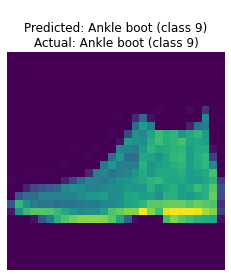

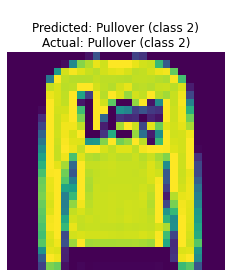

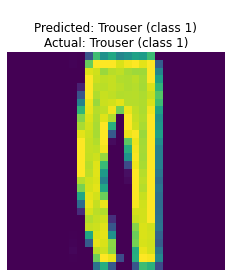

In [ ]:
def show(idx, title):
    plt.figure()
    plt.imshow(test_images[idx].reshape(28,28))    
    plt.axis('off')
    plt.title(f'\n{title}')
  
# ndarray is not JSON serializable, so we have to transform 
# test_images to a regular Python list before making the HTTP request.

# Check shape of data
num_samples = 3
test_payload = test_images[0:num_samples]
print(f"Shape of data passed to JSON payload: {test_payload.shape}")

if test_payload.shape[0] == 1:
    sample_text = 'sample'
else:
    sample_text = 'samples'
print(f"shape[0] is {test_payload.shape[0]}, this means we will pass {test_payload.shape[0]} {sample_text}.")

HR()

img_data = test_payload.tolist()

# Show just a tiny subset
data = json.dumps({
    "signature_name": "serving_default",
    "instances": img_data
})


headers = {
    "Content-type": "application_json"
}

json_response = requests.post(
    f'http://localhost:8501/v1/models/{model_name}:predict',
    data=data,
    headers=headers
)

# the JSON object must be str, bytes or bytearray, not Response
predictions = json.loads(json_response.text)['predictions']

for i in range(0, num_samples):
    forecast = class_names[np.argmax(predictions[i])]
    forecast_class = np.argmax(predictions[i])
    actual = class_names[test_labels[i]]
    actual_class = test_labels[i]
    show(
        i, 
        f"""Predicted: {forecast} (class {forecast_class})\nActual: {actual} (class {actual_class})"""
    )
    
print("Properties of response:\n")
pp.pprint(json_response.__dict__)

---
<a name="9.0"></a>
# 9. End and clean up processes
<a href="#top">[back to top]</a>

In [ ]:
!killall tensorflow_model_server -v

Killed tensorflow_model_server(1265) with signal 15


---
## Content Attribution

Portions of this page are modifications based on work created and shared by Google and used according to terms described in the Creative Commons 4.0 Attribution License.

This notebook is originally based on [Train and serve a TensorFlow model with TensorFlow Serving](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple), created by Google.

## Code Attribution

Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.